In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import quantum_imaging as qi
from IPython.display import Image
import numpy as np
%matplotlib inline

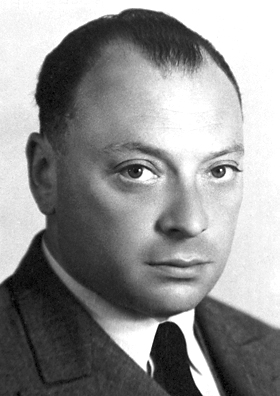

In [2]:
Image("pauli.jpg")

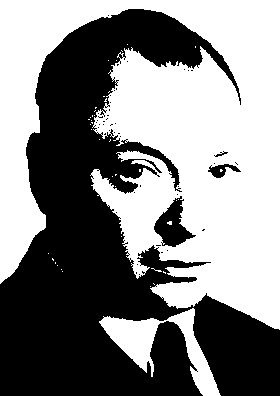

In [3]:
image_pauli = qi.convert_to_bw("pauli.jpg")
qi.image_from_array(image_pauli)

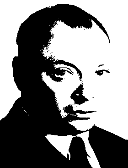

In [6]:
resized_image_pauli = qi.resize_array(image_pauli, size=(128, 168))
qi.image_from_array(resized_image_pauli)

In [7]:
array_binary_pauli = qi.binary_encode(resized_image_pauli)
qi.save_bin_array_to_csv('quantum_pauli.csv', array_binary_pauli)

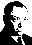

In [10]:
resized_image_pauli_tiny = qi.resize_array(image_pauli, size=(32, 45))
qi.image_from_array(resized_image_pauli_tiny)

In [11]:
array_binary_pauli_tiny = qi.binary_encode(resized_image_pauli_tiny)
qi.save_bin_array_to_csv('quantum_pauli_tiny.csv', array_binary_pauli_tiny)

# Use one-hot encoding drawing file to create a Quantum circuit and rebuild the image with the circuit result

# Only support square images (i.e: 32x32px, 64x64px)

In [12]:
def create_base_circuit(num_qubits):

    cr = ClassicalRegister(num_qubits, "c0")
    qr = QuantumRegister(num_qubits, "q0")

    base_circuit = QuantumCircuit(qr, cr)

    base_circuit.initialize(Statevector.from_label('1'*num_qubits).data, range(num_qubits));

    #[base_circuit.initialize([0, 1], i) for i in range(num_qubits)];
    
    return base_circuit

def splitting_chunks(n_cols, num_qubits):

    chunk_split = num_qubits

    num_splitting = int(n_cols / chunk_split) + (1 if int(n_cols % chunk_split) > 0 else 0)
    
    return num_splitting

def create_circuits(n_circuits, num_qubits):
    
    circuits = []

    for i in range(n_circuits):
        circuits.append(create_base_circuit(num_qubits))
        
    return circuits

def split_str(s):
    
    array = [ch for ch in s]
    
    return array

def rework_result_count(counts):

    result_value = [key for key, val in sorted(counts.items(), key = lambda ele: ele[1], reverse = True)]

    reverse_val = result_value[0][::-1]
    
    return reverse_val
    
def apply_gate(circuit, row, num_qubits):
    
    zeros = np.where(row == 0)
    zeros = zeros[0]

    circuit.barrier()
    
    if np.size(zeros) > 0:
        circuit.x(zeros.tolist())
    else:
        circuit.id(list(range(num_qubits)))
        
    circuit.measure(range(num_qubits), range(num_qubits))
    
    return circuit

def rebuild_image_quantum(binary_data, cols_items, splitting, num_qubits, backend, num_shots=1):
    
    final_array = []

    for item in binary_data:

        row_value = ''

        step = 0

        circ_copy = create_circuits(splitting, num_qubits)

        for circuit in circ_copy: 

            temp_step = step + num_qubits
            long_step = temp_step

            if long_step >= cols_items:

                long_step = cols_items

            chunk = item[step:long_step]

            apply_circuit = apply_gate(circuit, chunk, num_qubits)

            sim_counts = execute(circuit, backend=backend, shots=num_shots).result().get_counts()

            row_value = row_value + rework_result_count(sim_counts)

            if temp_step >= cols_items:

                diff = temp_step - cols_items

                row_value = row_value[:-diff]

            else:

                step = step + num_qubits

        array_row = split_str(row_value)

        final_array.append(array_row)

    rework_data = np.array(final_array, dtype='uint8')
    
    return rework_data

In [13]:
# Simulator
qasm_sim = Aer.get_backend("aer_simulator")

# Number of circuit qubits
n_qubits = 5

In [14]:
binary_data_array = qi.load_bin_array_from_csv('quantum_pauli.csv')

cols_items = binary_data_array.shape[1]
splitting = splitting_chunks(cols_items, n_qubits)

rework_image = rebuild_image_quantum(binary_data_array, cols_items, splitting, n_qubits, qasm_sim)
rework_image.shape

(168, 128)

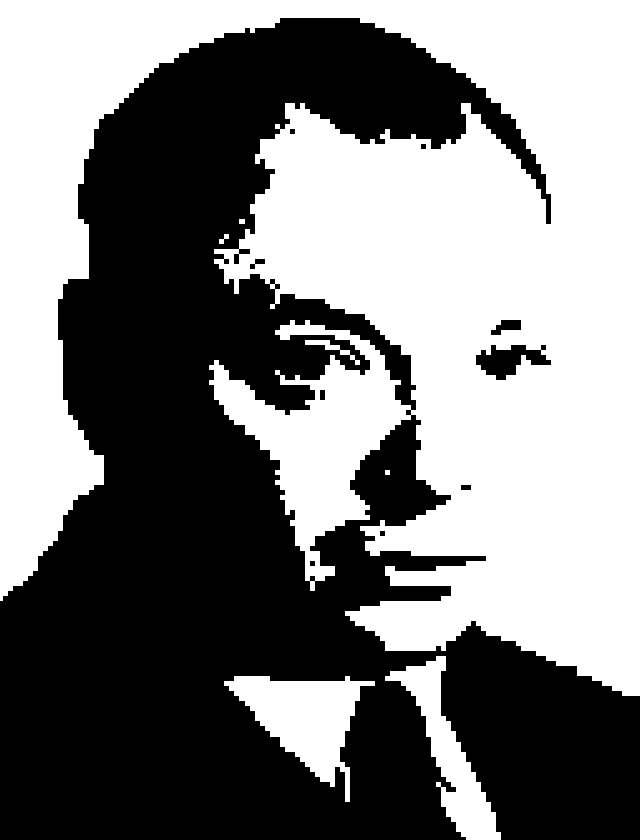

In [15]:
rebuild_data = qi.rebuild_binary_array(rework_image)
#qi.image_from_array(rebuild_data)
scaled_image = qi.scale_binary_image(rebuild_data, 5)
qi.image_from_array(scaled_image)

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table